Length of stay in hospital with only short term consideration

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

# Importing Data

In [183]:
def import_files(file_name):
    """Reads in all CSV files and converts them to dataframes"""
    imported_file = pd.read_csv(f'full_data/{file_name}.csv')
    print(f"{file_name}.csv was imported")
    return imported_file

def creating_dataframe(admission, patients, diagnosis, services, icu):
    """Takes in individual dataframes and combines them on common columns"""
    adm = import_files(admission)
    pat = import_files(patients)
    diag = import_files(diagnosis)
    serv = import_files(services)
    icu = import_files(icu)
    print("All files loaded")
    return adm, pat, diag, serv, icu

def cleaning_column_names(data):
    data.columns = data.columns.str.strip().str.lower()
    return data

def merging_data(adm, pat, diag, serv, icu):
    raw_data = adm.merge(pat, how='outer', on='subject_id')
    raw_data = raw_data.merge(diag, how='outer', on=('subject_id', 'hadm_id'))
    raw_data = raw_data.merge(serv, how='outer', on=('subject_id', 'hadm_id'))
    raw_data = raw_data.merge(icu, how='outer', on=('subject_id', 'hadm_id'))
    print("All files were merged.")
    return raw_data

def selecting_columns(data):
    """Selects only relevant columns from the dataframe"""
    keeping_cols = ['subject_id',
                'hadm_id',
                'admittime',
                'dischtime',
                'admission_type',
                'admission_location',
                'insurance',
                'religion',
                'marital_status',
                'ethnicity',
                'gender',
                'dob',
                'deathtime',
                'icd9_code',
                'curr_service',
                "first_careunit"
               ]
    raw_data = data[keeping_cols]
    print("Appropriate columns were selected.")
    return raw_data

def import_data():
    adm, pat, diag, serv, icu = creating_dataframe('admissions_data', 'patient_data', 'diagnoses_icd_data', 'services_data', 'icustays')
    adm_c = cleaning_column_names(adm)
    pat_c = cleaning_column_names(pat)
    diag_c = cleaning_column_names(diag)
    serv_c = cleaning_column_names(serv)
    icu_c = cleaning_column_names(icu)
    merged_data = merging_data(adm_c, pat_c, diag_c, serv_c, icu_c)
    raw_data_selected_cols = selecting_columns(merged_data)
    print("Files imported.")
    print("Columns selected.")
    return raw_data_selected_cols

In [184]:
raw_data = import_data()

FileNotFoundError: [Errno 2] File b'full_data/admissions_data.csv' does not exist: b'full_data/admissions_data.csv'

In [185]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 853619 entries, 0 to 853618
Data columns (total 17 columns):
subject_id            853619 non-null int64
hadm_id               853619 non-null int64
admittime             853619 non-null object
dischtime             853619 non-null object
admission_type        853619 non-null object
admission_location    853619 non-null object
insurance             853619 non-null object
religion              849805 non-null object
marital_status        778707 non-null object
ethnicity             853619 non-null object
gender                853619 non-null object
dob                   853619 non-null object
deathtime             112472 non-null object
icd9_code             853572 non-null object
curr_service          853307 non-null object
first_careunit        2393 non-null object
los                   853619 non-null float64
dtypes: float64(1), int64(2), object(14)
memory usage: 117.2+ MB


# Cleaning Data

In [186]:
def add_los_columns(data):
    """Adds a new column to indicate length of stay in the hospital by
    subtracting the patient's admission time from their discharge time.
    Removes outliers in the data above 2 standard deviations.
    """
    data['los'] = (pd.to_datetime(data.dischtime) - pd.to_datetime(data.admittime)).dt.total_seconds()/86400
    data = data.drop(columns=['dischtime'])
    print("Length of stay column was added.")
    return data

def creating_age_column(data):
    """Creates an age column by subtracting the patient's date of birth from their admittime.
    Then removes any ages greater than 105 which are caused by a date adjustment error (see note).
    Note: for each user, dates have been modified by a random number of years. The modification
    number of years is consistent within a patient's listings accross all columns.
    """
    data['age'] = (pd.to_datetime(data.admittime).dt.date - pd.to_datetime(data.dob).dt.date)
    data['age'] = data['age'].apply(lambda x: round(x.days / 365,0))
    data = data[data.age < 105]
    data = data.drop(columns='dob')
    print("Age column was added.")
    print("DOB column was dropped")
    return data

def removing_dead_subjects(data):
    """Removes all subjects that died while in the hospital as their length of stay is
    not indicative of a standard patient's LOS"""
    data = data[data.deathtime.isna()]
    data = data.drop(columns = ['deathtime'])
    print("Patients who died in the hospital were removed.")
    return data

def isolating_firsts(data):
    grp_by_first_vis = data.groupby(['subject_id', 'hadm_id'])['admittime'].agg(['first']).reset_index()
    firsts_visits = grp_by_first_vis.merge(data, how='left', on=('subject_id', 'hadm_id'))
    print('Data isolated to first time visits only')
    firsts_visits = firsts_visits.drop(columns=['admittime', 'first'])
    return firsts_visits

def drop_nulls(data):
    data.first_careunit = data.first_careunit.fillna('not_admitted')
    null_dropped_data = data.dropna()
    print('Null values dropped.')
    return null_dropped_data

def add_cols_remove_rows(data):
    los_added = add_los_columns(data)
    add_age = creating_age_column(los_added)
    removed_daed = removing_dead_subjects(add_age)
    first_visits = isolating_firsts(removed_daed)
    null_dropped = drop_nulls(first_visits)
    return null_dropped

In [187]:
cleaned_data = add_cols_remove_rows(raw_data)

Length of stay column was added.
Age column was added.
DOB column was dropped
Patients who died in the hospital were removed.
Data isolated to first time visits only
Null values dropped.


# Transforming ICD9

In [188]:
cleaned_data.icd9_code = cleaned_data.icd9_code.apply(lambda x: '.1' if 'V' in x else x)
cleaned_data.icd9_code = cleaned_data.icd9_code.apply(lambda x: '.8' if 'M' in x else x)
cleaned_data.icd9_code = cleaned_data.icd9_code.apply(lambda x: '.5' if 'E' in x else x)
cleaned_data.icd9_code = cleaned_data.icd9_code.apply(lambda x: x[:3] if ('E' not in x) & ('M' not in x) & ('V' not in x)else x)

cleaned_data.icd9_code = cleaned_data.icd9_code.astype(float)

def f(row):
    if 1 <= row['icd9_code'] <= 139:
        val = 'Parasitic_Disease'
    elif 140 <= row['icd9_code'] <= 239:
        val = 'Neoplasm'
    elif 240 <= row['icd9_code'] <= 279:
        val = 'Endocrine'
    elif 280 <= row['icd9_code'] <= 289:
        val = "Blood"
    elif 290 <= row['icd9_code'] <= 319:
        val = "Mental_Disorder"
    elif 320 <= row['icd9_code'] <= 389:
        val = "Nervous_System"
    elif 390 <= row['icd9_code'] <= 459:
        val = "Circulatory_System"
    elif 460 <= row['icd9_code'] <= 519:
        val = "Respiratory_System"
    elif 520 <= row['icd9_code'] <= 579:
        val = "Digestive_System"
    elif 580 <= row['icd9_code'] <= 629:
        val = "Genitourinary_System"
    elif 630 <= row['icd9_code'] <= 679:
        val = "Pregnancy"
    elif 680 <= row['icd9_code'] <= 709:
        val = "Skin"
    elif 710 <= row['icd9_code'] <= 739:
        val = "Musculoskeletal"
    elif 740 <= row['icd9_code'] <= 759:
        val = "Congenital_Anomalies"
    elif 760 <= row['icd9_code'] <= 779:
        val = "Perinatal"
    elif 780 <= row['icd9_code'] <= 799:
        val = "Ill-Defined"
    elif 800 <= row['icd9_code'] <= 999:
        val = "Injury/Poison"
    elif row['icd9_code'] < .4:
        val = "Supplemental_factors"
    elif .4 <= row['icd9_code'] < .7:
        val = "External_Cause_Inj_Poison"
    elif .7 <= row['icd9_code'] < .9:
        val = "Morphology_of_Neoplasms"     
    else:
        val = row['icd9_code']
    return val


cleaned_data['diagnoses'] = cleaned_data.apply(f, axis=1)
cleaned_data = cleaned_data.drop(columns=['icd9_code'])

# Adjusting to short term only

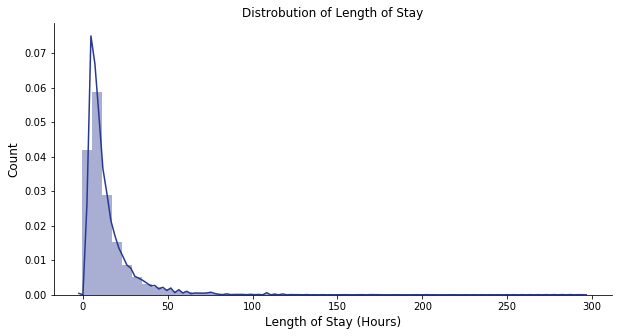

In [189]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(10,5))
los_distro = sns.distplot(cleaned_data.los, color=bidmc_deep_blue)
    
los_distro.set_title('Distrobution of Length of Stay', fontsize=12)
los_distro.set_ylabel('Count', fontsize=12)
los_distro.set_xlabel('Length of Stay (Hours)', fontsize=12);
sns.despine()

In [190]:
cleaned_data = cleaned_data[cleaned_data.los <= 30]
cleaned_data = cleaned_data[cleaned_data.los > 0]

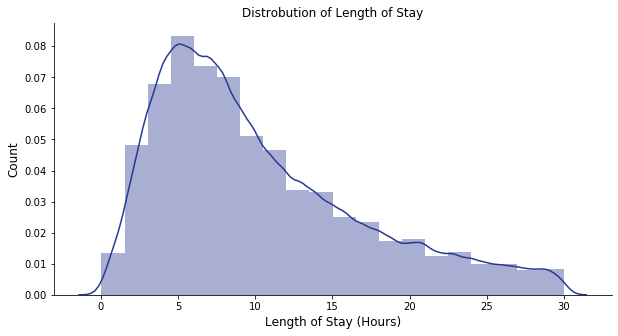

In [191]:
bidmc_deep_blue = '#283891'

plt.figure(figsize=(10,5))
los_distro = sns.distplot(cleaned_data.los, color=bidmc_deep_blue, bins=20)
    
los_distro.set_title('Distrobution of Length of Stay', fontsize=12)
los_distro.set_ylabel('Count', fontsize=12)
los_distro.set_xlabel('Length of Stay (Hours)', fontsize=12);
sns.despine()

In [192]:
copy_for_graphs = cleaned_data.copy()

# Dummy The Data

In [11]:
def dummy_cat_cols(data):
    """Creates dummy variables for each categorical column"""
    #cat_cols = ['admission_type', 'admission_location', 'insurance', 'religion', 'marital_status', 'ethnicity', 'gender', 'curr_service', 'diagnoses']
    cat_cols = [col for col in data.columns if (data[col].dtype == 'O')]
    
    dummied_data = pd.get_dummies(data, drop_first=True, columns=cat_cols)
    grouped_dummy_data = dummied_data.groupby('hadm_id').max().reset_index()
    select_cols = grouped_dummy_data.drop(columns = ['subject_id', 'hadm_id'])
    
    print("Dummy variables created.")
    
    return select_cols

In [12]:
def splitting_test_and_train(data):

    X, y = data.drop('los', axis=1), data['los']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

    #this helps with the way kf will generate indices below
    print("Train and test data are separated")

    return X_train, X_test, y_train, y_test

In [13]:
def cross_val_testing_lr(X_train, X_test, y_train, y_test):
    
    kf = KFold(n_splits=10, shuffle=True, random_state = 71)
    
    cv_lm_r2s, in_sample_r2s = [], [] #collect the validation results for both models
    cv_lm_rmse, in_sample_rmses = [], []
    cv_lm_mae, in_sample_mae = [], []
    
    print("Kfolds created. Running linear regression.")

    for train_ind, val_ind in kf.split(X_train,y_train):

        X_tr, y_tr = X_train.iloc[train_ind], y_train.iloc[train_ind]
        X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]

        #defining simple linear regression
        lm = LinearRegression()
        lm.fit(X_tr, y_tr)
        in_sample_predict = lm.predict(X_tr)
        out_of_sample_predict = lm.predict(X_val)
        
        cv_lm_r2s.append(lm.score(X_val, y_val))
        in_sample_r2s.append(lm.score(X_tr, y_tr))
        
        cv_lm_rmse.append(np.sqrt(mean_squared_error(y_val, out_of_sample_predict)))
        in_sample_rmses.append(np.sqrt(mean_squared_error(y_tr, in_sample_predict)))
        
        cv_lm_mae.append(mean_absolute_error(y_val, out_of_sample_predict))
        in_sample_mae.append(mean_absolute_error(y_tr, in_sample_predict))


    print('\nLinear regression scores r^2: ', cv_lm_r2s, '\n')
    print(f'Linear regression mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}\n')
    print(f"Mean r^2 for in sample data: {np.mean(in_sample_r2s):.3f} +- {np.std(in_sample_r2s):.3f} \n\n")

    print('Linear regression scores rmse: ', cv_lm_rmse, '\n')
    print(f'Linear regression mean cv rmse: {np.mean(cv_lm_rmse):.3f} +- {np.std(cv_lm_rmse):.3f}\n')
    print(f"Mean rmse for in sample data: {np.mean(in_sample_rmses):.3f} +- {np.std(in_sample_rmses):.3f}")
    
    print('Linear regression scores mae: ', cv_lm_mae, '\n')
    print(f'Linear regression mean cv rmse: {np.mean(cv_lm_mae):.3f} +- {np.std(cv_lm_mae):.3f}\n')
    print(f"Mean rmse for in sample data: {np.mean(in_sample_mae):.3f} +- {np.std(in_sample_mae):.3f}")

    return

In [14]:
dummied_clean = dummy_cat_cols(cleaned_data)

Dummy variables created.


In [15]:
X_train, X_test, y_train, y_test = splitting_test_and_train(dummied_clean)

Train and test data are separated


In [16]:
baseline_regression = cross_val_testing_lr(X_train, X_test, y_train, y_test)

Kfolds created. Running linear regression.

Linear regression scores r^2:  [0.286612369322805, 0.2548157467535406, 0.29330848406442156, 0.2505946654674024, 0.26896572513122685, 0.2591347940619333, 0.2993731926419662, 0.28727762107257404, 0.2667552684062501, 0.28886279280737437] 

Linear regression mean cv r^2: 0.276 +- 0.017

Mean r^2 for in sample data: 0.283 +- 0.002 


Linear regression scores rmse:  [5.1624098320732115, 5.290199686704344, 5.141965251643981, 5.164426645331165, 5.109615164395051, 5.108604283604757, 5.017226486677926, 5.094298990295632, 5.141400005569599, 5.2913430956625325] 

Linear regression mean cv rmse: 5.152 +- 0.080

Mean rmse for in sample data: 5.128 +- 0.009
Linear regression scores mae:  [3.838048782439395, 3.9233065047740165, 3.803242926693963, 3.853571676091869, 3.805379736071342, 3.7772394268150755, 3.7702434939974494, 3.821123571835893, 3.7927413852587737, 3.890892044236829] 

Linear regression mean cv rmse: 3.828 +- 0.047

Mean rmse for in sample data:

# Stats Models OLS

In [17]:
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

In [18]:
def SM_OLS(X_train, X_test, y_train, y_test):
    
    X_train = add_constant(X_train)
    
    kf = KFold(n_splits=10, shuffle=True, random_state = 71)
       
    print("Kfolds created. Running OLS.")

    for train_ind, val_ind in kf.split(X_train,y_train):

        X_tr, y_tr = X_train.iloc[train_ind], y_train.iloc[train_ind]
        X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]

        #Running OLS
        los_model = sm.OLS(y_tr, X_tr)
        results = los_model.fit()


    return results.summary()

In [19]:
SM_OLS(X_train, X_test, y_train, y_test)

/Users/mollyliebeskind/opt/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Kfolds created. Running OLS.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    los   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     89.87
Date:                Thu, 23 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:39:04   Log-Likelihood:                -87186.
No. Observations:               28580   AIC:                         1.746e+05
Df Residuals:                   28455   BIC:                         1.757e+05
Df Model:                         124                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
const                                                                 -3.0612      3.102     -0.987      0.324      -9.141       3.018
age                                                                    0.0034      0.003      1.174      0.240      -0.002       0.009
admission_type_EMERGENCY                                               2.0658      0.188     10.992      0.000       1.697       2.434
admission_type_NEWBORN                                                 1.9586      2.481      0.789      0.430      -2.904       6.821
admission_type_URGENT                                                  2.8117      0.246     11.422      0.000       2.329       3.294
admission_location_CLINIC REFERRAL/PREMATURE                           0.0887      1.544      0.057      0.954      -2.937       3.115
admission_location_EMERGENCY ROOM ADMIT                                1.1821      1.543      0.766      0.444      -1.843       4.207
admission_location_HMO REFERRAL/SICK                                  -1.6790      2.962     -0.567      0.571      -7.484       4.126
admission_location_PHYS REFERRAL/NORMAL DELI                           1.4888      1.536      0.969      0.332      -1.521       4.499
admission_location_TRANSFER FROM HOSP/EXTRAM                           1.9474      1.544      1.261      0.207      -1.079       4.974
admission_location_TRANSFER FROM OTHER HEALT                           1.5646      1.822      0.859      0.390      -2.006       5.135
admission_location_TRANSFER FROM SKILLED NUR                          -0.6273      1.620     -0.387      0.699      -3.802       2.547
admission_location_TRSF WITHIN THIS FACILITY                          -1.6490      2.993     -0.551      0.582      -7.515       4.217
insurance_Medicaid                                                    -0.2724      0.200     -1.364      0.172      -0.664       0.119
insurance_Medicare                                                    -0.5243      0.191     -2.742      0.006      -0.899      -0.149
insurance_Private                                                     -0.4293      0.185     -2.320      0.020      -0.792      -0.067
insurance_Self Pay                                                    -0.7924      0.371     -2.136      0.033      -1.520      -0.065
religion_BAPTIST                                                      -1.2222      1.477     -0.828      0.408      -4.116       1.672
religion_BUDDHIST                                                     -1.2207      0.881     -1.386      0.166      -2.947       0.505
religion_CATHOLIC                                                     -1.1688      0.734     -1.592      0.111   

# Featuring Engineering (All Features)

In [20]:
def compressing_admission_type(data):
    eng_data = data
    eng_data.admission_type = eng_data.admission_type.apply(lambda x: 'EMERGENCY' if x == 'URGENT' else x)
    return eng_data

In [21]:
def r(row):
    if 0 <= row['age'] <= 3:
        val = 'Baby'
    elif 3 <= row['age'] <= 18:
        val = 'Child/Teen'
    elif 19 <= row['age'] <= 40:
        val = 'Young_Aduld'
    elif 41 <= row['age'] <= 60:
        val = "Adult"
    elif 61 <= row['age'] <= 100:
        val = "Senior"
    return val


def age_to_cat(data):
    eng_data = data
    eng_data['age'] = eng_data.apply(r, axis=1)
    return eng_data

In [22]:
def compressing_careunit(data):
    eng_data = data
    eng_data.first_careunit = eng_data.first_careunit.apply(lambda x: 'ICU' if (x == 'MICU') | (x == 'SICU') | (x == 'CCU') | (x == 'CSRU') | (x == 'TSICU') else x)
    return eng_data

In [23]:
def compressing_curr_serv(data):
    eng_data = data
    eng_data.curr_service = eng_data.curr_service.apply(lambda x: 'SURGERGY' if (x == 'CSURG') | (x == 'NSURG') | (x == 'ORTHO') | (x == 'PSURG') | (x == 'SURG') | (x == 'TSURG') | (x == 'VSURG') else x)
    eng_data.curr_service = eng_data.curr_service.apply(lambda x: "MED" if (x == 'CMED') | (x == 'OMED') | (x == 'NMED') | (x == 'TRAUM') else x)
    eng_data.curr_service = eng_data.curr_service.apply(lambda x: "GYNOCOLOGY/NEWBORN" if (x == 'NB') | (x == 'NBB') | (x == 'OBS') | (x == 'GYN') else x)
    eng_data.curr_service = eng_data.curr_service.apply(lambda x: "OTHER" if (x == "GU") | (x == "ENT") | (x == "DENT") | (x == "PSYCH") else x)
    return eng_data

In [24]:
def compressing_ethnicity(data):
    eng_data = data
    eng_data.ethnicity = eng_data.ethnicity.apply(lambda x: 'WHITE' if ("WHITE" in x) else x)
    eng_data.ethnicity = eng_data.ethnicity.apply(lambda x: "ASIAN" if ("ASIAN" in x) else x)
    eng_data.ethnicity = eng_data.ethnicity.apply(lambda x: "HISPANIC/LATINO" if ("LATINA" in x) | ("HISPANIC" in x) else x)
    eng_data.ethnicity = eng_data.ethnicity.apply(lambda x: "OTHER/UNKNOWN" if (x=="AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE") | (x=="SOUTH AMERICAN") | (x=="CARIBBEAN ISLAND") | (x=="NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER") |(x=="AMERICAN INDIAN/ALASKA NATIVE") | (x=="MIDDLE EASTERN") | (x=="PORTUGUESE") | (x=="MULTI RACE ETHNICITY") | (x=="PATIENT DECLINED TO ANSWER") | (x=="OTHER") | ("UNKNOWN" in x) | ("OBTAIN" in x) else x)
    eng_data.ethnicity = eng_data.ethnicity.apply(lambda x: "BLACK_AFRICAN/OTHER" if ("BLACK" in x) else x)
    return data

In [25]:
def compressing_marital_status(data):
    eng_data = data
    eng_data.marital_status = eng_data.marital_status.apply(lambda x: 'LIFE_PARTNER' if (x == 'MARRIED') | (x == 'LIFE PARTNER') else x)
    eng_data.marital_status = eng_data.marital_status.apply(lambda x: 'SINGLE' if (x == 'WIDOWED') | (x == 'DIVORCED') | (x == 'SEPARATED') else x)
    eng_data.marital_status = eng_data.marital_status.apply(lambda x: 'OTHER/UNKNOWN' if (x == 'UNKNOWN (DEFAULT)') else x)
    return data

In [26]:
def compressing_religion(data):
    eng_data = data
    eng_data.religion = eng_data.religion.apply(lambda x: 'RELIGIOUS' if (x == "LUTHERAN") | (x == "METHODIST") | (x == "HEBREW") | (x == "BAPTIST") | (x == "HINDU") | (x == "UNITARIAN-UNIVERSALIST") | (x == "ROMANIAN EAST. ORTH") | (x == "7TH DAY ADVENTIST") | (x == "JEHOVAH'S WITNESS") | (x == 'MUSLIM') | (x == 'BUDDHIST') | (x == 'CHRISTIAN SCIENTIST') | (x == 'GREEK ORTHODOX') | (x == 'EPISCOPALIAN') | (x == 'OTHER') | (x == 'JEWISH') | (x == 'CATHOLIC') | (x == 'PROTESTANT QUAKER') else x)
    return data

In [27]:
def compressing_admit_location(data):
    eng_data = data
    eng_data.admission_location = eng_data.admission_location.apply(lambda x: 'ER_ADMIT' if (x == 'EMERGENCY ROOM ADMIT ') else x)
    eng_data.admission_location = eng_data.admission_location.apply(lambda x: 'REFERRAL' if (x == 'HMO REFERRAL/SICK') | (x == 'PHYS REFERRAL/NORMAL DELI') | (x == 'CLINIC REFERRAL/PREMATURE') else x)
    eng_data.admission_location = eng_data.admission_location.apply(lambda x: 'TRANSFER' if (x == 'TRANSFER FROM HOSP/EXTRAM') | (x == 'TRANSFER FROM SKILLED NUR') | (x == 'TRANSFER FROM OTHER HEALT') | (x == 'TRSF WITHIN THIS FACILITY')else x)
    eng_data.admission_location = eng_data.admission_location.apply(lambda x: 'OTHER/UNKNOWN' if (x == '** INFO NOT AVAILABLE **')  else x)
    return eng_data

In [28]:
fe_data = compressing_admission_type(cleaned_data)
fe_data = age_to_cat(fe_data)
fe_data = compressing_careunit(fe_data)
fe_data = compressing_curr_serv(fe_data)
fe_data = compressing_ethnicity(fe_data)
fe_data = compressing_marital_status(fe_data)
fe_data = compressing_religion(fe_data)
fe_data = compressing_admit_location(fe_data)

In [29]:
fe_dummied = dummy_cat_cols(fe_data)

Dummy variables created.


In [30]:
fe_dummied.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39694 entries, 0 to 39693
Data columns (total 45 columns):
los                                    39694 non-null float64
admission_type_EMERGENCY               39694 non-null uint8
admission_type_NEWBORN                 39694 non-null uint8
admission_location_OTHER/UNKNOWN       39694 non-null uint8
admission_location_REFERRAL            39694 non-null uint8
admission_location_TRANSFER            39694 non-null uint8
insurance_Medicaid                     39694 non-null uint8
insurance_Medicare                     39694 non-null uint8
insurance_Private                      39694 non-null uint8
insurance_Self Pay                     39694 non-null uint8
religion_RELIGIOUS                     39694 non-null uint8
religion_UNOBTAINABLE                  39694 non-null uint8
marital_status_OTHER/UNKNOWN           39694 non-null uint8
marital_status_SINGLE                  39694 non-null uint8
ethnicity_BLACK_AFRICAN/OTHER          39694 non-

In [31]:
X_train_fe, X_test_fe, y_train_fe, y_test_fe = splitting_test_and_train(fe_dummied)
feature_engineering_regression = cross_val_testing_lr(X_train_fe, X_test_fe, y_train_fe, y_test_fe)

Train and test data are separated
Kfolds created. Running linear regression.

Linear regression scores r^2:  [0.2621554403969155, 0.24154223524172247, 0.26359498864307174, 0.24040481503939615, 0.24452355136247453, 0.23027773157305487, 0.27959706610521595, 0.27304423607652895, 0.24340162113904595, 0.2691812359914858] 

Linear regression mean cv r^2: 0.255 +- 0.016

Mean r^2 for in sample data: 0.258 +- 0.002 


Linear regression scores rmse:  [5.250155075548802, 5.3371072710084135, 5.248951577426543, 5.1994190924764965, 5.194332991279758, 5.207145214324186, 5.087542703501495, 5.144915247978385, 5.222634355292643, 5.364065425898534] 

Linear regression mean cv rmse: 5.226 +- 0.078

Mean rmse for in sample data: 5.218 +- 0.009
Linear regression scores mae:  [3.90532947716591, 3.958287640188168, 3.8812517117090715, 3.887628135615149, 3.858908269373864, 3.8595494715549754, 3.83243381826227, 3.8486723570482826, 3.8557019031701762, 3.9415749424989985] 

Linear regression mean cv rmse: 3.883 +

In [32]:
SM_OLS(X_train_fe, X_test_fe, y_train_fe, y_test_fe)

Kfolds created. Running OLS.


/Users/mollyliebeskind/opt/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    los   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     222.9
Date:                Thu, 23 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:39:45   Log-Likelihood:                -87686.
No. Observations:               28580   AIC:                         1.755e+05
Df Residuals:                   28535   BIC:                         1.758e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -1.9042      0.798     -2.386      0.017      -3.468      -0.340
admission_type_EMERGENCY                0.7706      0.114      6.784      0.000       0.548       0.993
admission_type_NEWBORN                  0.7910      1.328      0.596      0.551      -1.812       3.394
admission_location_OTHER/UNKNOWN       -2.2005      1.557     -1.413      0.158      -5.252       0.851
admission_location_REFERRAL            -0.9764      0.082    -11.946      0.000      -1.137      -0.816
admission_location_TRANSFER             0.4019      0.095      4.213      0.000       0.215       0.589
insurance_Medicaid                     -0.3414      0.202     -1.694      0.090      -0.736       0.054
insurance_Medicare                     -0.6384      0.191     -3.343      0.001      -1.013      -0.264
insurance_Private                      -0.3732      0.186     -2.004      0.045      -0.738      -0.008
insurance_Self Pay                     -0.6500      0.376     -1.728      0.084      -1.387       0.087
religion_RELIGIOUS                      0.3684      0.078      4.707      0.000       0.215       0.522
religion_UNOBTAINABLE                   0.1072      0.128      0.835      0.404      -0.144       0.359
marital_status_OTHER/UNKNOWN            0.4112      0.398      1.033      0.301      -0.369       1.191
marital_status_SINGLE                   0.0399      0.068      0.584      0.559      -0.094       0.174
ethnicity_BLACK_AFRICAN/OTHER          -0.2144      0.221     -0.968      0.333      -0.648       0.220
ethnicity_HISPANIC/LATINO              -0.0311      0.253     -0.123      0.902      -0.527       0.465
ethnicity_OTHER/UNKNOWN                 0.3825      0.222      1.721      0.085      -0.053       0.818
ethnicity_WHITE                        -0.0775      0.204     -0.380      0.704      -0.477       0.322
gender_M                                0.0542      0.065      0.837      0.403      -0.073       0.181
curr_service_MED                        1.4908      0.108     13.770      0.000       1.279       1.703
curr_service_OTHER                      1.7634      0.269      6.545      0.000       1.235       2.291
curr_service_SURGERGY                   4.5152      0.095     47.504      0.000       4.329       4.702
first_careunit_not_admitted             2.4757      0.732      3.382      0.001       1.041       3.910
age_Baby                                2.9782      1.426      2.088      0.037       0.183       5.774
age_Child/Teen                         -0.3988      0.562     -0.710      0.478      -1.500       0.702
age_Senior                              0.2343      0.085      2.769      0.006       0.068       0.400
age_Young_Aduld                         0.0574      0.118      0.48

# Selecting and Removing columns with high P-values

In [33]:
high_p_val_columns = ['admission_type_NEWBORN', 'insurance_Medicare', 'insurance_Private', 'insurance_Medicaid', 'insurance_Self Pay','religion_UNOBTAINABLE','marital_status_OTHER/UNKNOWN','marital_status_SINGLE','ethnicity_OTHER/UNKNOWN','gender_M','age_Child/Teen','age_Young_Aduld','diagnoses_Musculoskeletal']

In [34]:
narrowed_columns = fe_dummied.drop(columns=high_p_val_columns)

In [35]:
X_train_narrow, X_test_narrow, y_train_narrow, y_test_narrow = splitting_test_and_train(narrowed_columns)

Train and test data are separated


In [36]:
narrowed_columns_regression = cross_val_testing_lr(X_train_narrow, X_test_narrow, y_train_narrow, y_test_narrow)

Kfolds created. Running linear regression.

Linear regression scores r^2:  [0.26204092236431265, 0.2421265808777692, 0.2644204508823016, 0.24056515915275256, 0.24418996498920287, 0.23013895442393495, 0.2786257284891961, 0.27218090288342034, 0.2438654677090496, 0.2702320121963737] 

Linear regression mean cv r^2: 0.255 +- 0.016

Mean r^2 for in sample data: 0.257 +- 0.002 


Linear regression scores rmse:  [5.2505624879876125, 5.335050916380273, 5.2460088854724125, 5.198870286834979, 5.195479663337684, 5.207614604537181, 5.090971379821633, 5.1479693940131535, 5.221033193762725, 5.36020779383453] 

Linear regression mean cv rmse: 5.225 +- 0.076

Mean rmse for in sample data: 5.220 +- 0.008
Linear regression scores mae:  [3.9007475315613513, 3.9547464742062775, 3.8780219095679827, 3.886679617776235, 3.856762932428998, 3.857633871637326, 3.8336151557609814, 3.849024591960223, 3.8524915368448536, 3.9379017379129095] 

Linear regression mean cv rmse: 3.881 +- 0.038

Mean rmse for in sample d

In [37]:
SM_OLS(X_train_narrow, X_test_narrow, y_train_narrow, y_test_narrow)

Kfolds created. Running OLS.


/Users/mollyliebeskind/opt/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    los   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     315.5
Date:                Thu, 23 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:39:47   Log-Likelihood:                -87698.
No. Observations:               28580   AIC:                         1.755e+05
Df Residuals:                   28548   BIC:                         1.757e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -1.8438      0.754     -2.445      0.014      -3.322      -0.366
admission_type_EMERGENCY                0.7690      0.113      6.792      0.000       0.547       0.991
admission_location_OTHER/UNKNOWN       -2.3319      1.554     -1.501      0.133      -5.378       0.714
admission_location_REFERRAL            -0.9675      0.082    -11.869      0.000      -1.127      -0.808
admission_location_TRANSFER             0.4252      0.095      4.494      0.000       0.240       0.611
religion_RELIGIOUS                      0.3191      0.069      4.616      0.000       0.184       0.455
ethnicity_BLACK_AFRICAN/OTHER          -0.5324      0.132     -4.024      0.000      -0.792      -0.273
ethnicity_HISPANIC/LATINO              -0.3181      0.180     -1.766      0.077      -0.671       0.035
ethnicity_WHITE                        -0.4140      0.096     -4.334      0.000      -0.601      -0.227
curr_service_MED                        1.5014      0.108     13.886      0.000       1.289       1.713
curr_service_OTHER                      1.7598      0.269      6.534      0.000       1.232       2.288
curr_service_SURGERGY                   4.5265      0.095     47.744      0.000       4.341       4.712
first_careunit_not_admitted             2.4873      0.732      3.399      0.001       1.053       3.921
age_Baby                                3.7698      0.569      6.623      0.000       2.654       4.885
age_Senior                              0.0665      0.070      0.948      0.343      -0.071       0.204
diagnoses_Circulatory_System            0.8263      0.091      9.090      0.000       0.648       1.004
diagnoses_Congenital_Anomalies          0.5270      0.163      3.226      0.001       0.207       0.847
diagnoses_Digestive_System              0.7369      0.065     11.347      0.000       0.610       0.864
diagnoses_Endocrine                     0.1326      0.072      1.832      0.067      -0.009       0.274
diagnoses_External_Cause_Inj_Poison    -0.2828      0.081     -3.491      0.000      -0.442      -0.124
diagnoses_Genitourinary_System          1.3904      0.070     19.828      0.000       1.253       1.528
diagnoses_Ill-Defined                   1.1399      0.068     16.779      0.000       1.007       1.273
diagnoses_Injury/Poison                 2.0230      0.077     26.172      0.000       1.872       2.175
diagnoses_Mental_Disorder              -0.2303      0.070     -3.303      0.001      -0.367      -0.094
diagnoses_Neoplasm                      1.0752      0.086     12.554      0.000       0.907       1.243
diagnoses_Nervous_System                0.5501      0.070      7.816      0.000       0.412       0.688
diagnoses_Parasitic_Disease             1.8441      0.079     23.26

# Cutting High P-Val Columns From Origonal Baseline Run

In [38]:
summary = SM_OLS(X_train, X_test, y_train, y_test)

Kfolds created. Running OLS.


In [39]:
results_as_html = summary.tables[1].as_html()
result_table = pd.read_html(results_as_html, header=0, index_col=0)[0]

In [40]:
high_p_table = result_table[result_table['P>|t|'] >.05]

In [41]:
high_p_vals = list(high_p_table.index)

In [42]:
without_any_high_p = dummied_clean.drop(high_p_vals[1:], axis=1)

In [43]:
X_train_no_p, X_test_fe_no_p, y_train_fe_no_p, y_test_fe_no_p = splitting_test_and_train(without_any_high_p)
feature_engineering_regression = cross_val_testing_lr(X_train_no_p, X_test_fe_no_p, y_train_fe_no_p, y_test_fe_no_p)

Train and test data are separated
Kfolds created. Running linear regression.

Linear regression scores r^2:  [0.27571594594427873, 0.2432594906079968, 0.28557590931795906, 0.24346691035146428, 0.2621252721698286, 0.2514688227680115, 0.2943026590609171, 0.2784491311099142, 0.25623486883254387, 0.2749696571774052] 

Linear regression mean cv r^2: 0.267 +- 0.017

Mean r^2 for in sample data: 0.270 +- 0.002 


Linear regression scores rmse:  [5.201686254487817, 5.331061865303709, 5.17002024889411, 5.188928508183546, 5.133465413327234, 5.134966452934036, 5.035348939810425, 5.125753416743845, 5.178152363868083, 5.342780260749151] 

Linear regression mean cv rmse: 5.184 +- 0.088

Mean rmse for in sample data: 5.174 +- 0.010
Linear regression scores mae:  [3.8863566186642267, 3.960120899057285, 3.8228061111182323, 3.8703979261863886, 3.8263658447286653, 3.7932623801808916, 3.783484087484398, 3.85216191316046, 3.8279397891650566, 3.9478576067080056] 

Linear regression mean cv rmse: 3.857 +- 0.

In [44]:
sum_2 = SM_OLS(X_train_no_p, X_test_fe_no_p, y_train_fe_no_p, y_test_fe_no_p)

Kfolds created. Running OLS.


/Users/mollyliebeskind/opt/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [45]:
results_as_html2 = sum_2.tables[1].as_html()
result_table2 = pd.read_html(results_as_html2, header=0, index_col=0)[0]

In [46]:
high_p_table2 = result_table2[result_table2['P>|t|'] >.05]

In [47]:
high_p_vals2 = list(high_p_table2.index)

In [48]:
without_any_high_p2 = without_any_high_p.drop(high_p_vals2, axis=1)

In [49]:
X_train_no_p2, X_test_fe_no_p2, y_train_fe_no_p2, y_test_fe_no_p2 = splitting_test_and_train(without_any_high_p2)
feature_engineering_regression = cross_val_testing_lr(X_train_no_p2, X_test_fe_no_p2, y_train_fe_no_p2, y_test_fe_no_p2)

Train and test data are separated
Kfolds created. Running linear regression.

Linear regression scores r^2:  [0.2753253356930472, 0.2476254367701487, 0.2861248308077503, 0.24327237199175722, 0.26189420915898254, 0.25182461046018045, 0.2937371306472938, 0.2782385703741408, 0.2561912732619349, 0.2743603055985365] 

Linear regression mean cv r^2: 0.267 +- 0.016

Mean r^2 for in sample data: 0.270 +- 0.002 


Linear regression scores rmse:  [5.203088713987449, 5.31566107934441, 5.168033697355968, 5.189595617639439, 5.134269114202355, 5.1337459459827475, 5.037366137875108, 5.126501252919109, 5.1783041195700195, 5.345024958407851] 

Linear regression mean cv rmse: 5.183 +- 0.086

Mean rmse for in sample data: 5.176 +- 0.010
Linear regression scores mae:  [3.8873266903780674, 3.9518993355483323, 3.8202688497050743, 3.873250161465373, 3.8282903272982054, 3.793330504908282, 3.785884691454972, 3.8527072399638094, 3.8277867668326353, 3.949833605183338] 

Linear regression mean cv rmse: 3.857 +- 0

In [50]:
sum_3 = SM_OLS(X_train_no_p2, X_test_fe_no_p2, y_train_fe_no_p2, y_test_fe_no_p2)

Kfolds created. Running OLS.


/Users/mollyliebeskind/opt/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [51]:
sum_3

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    los   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     283.4
Date:                Thu, 23 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:39:54   Log-Likelihood:                -87437.
No. Observations:               28580   AIC:                         1.750e+05
Df Residuals:                   28542   BIC:                         1.753e+05
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.3097      0.158      1.965      0.049       0.001       0.619
admission_type_EMERGENCY                1.6527      0.095     17.460      0.000       1.467       1.838
admission_type_URGENT                   3.1434      0.216     14.585      0.000       2.721       3.566
insurance_Medicare                     -0.2221      0.098     -2.261      0.024      -0.415      -0.030
insurance_Private                      -0.1974      0.100     -1.979      0.048      -0.393      -0.002
religion_NOT SPECIFIED                 -0.4770      0.076     -6.314      0.000      -0.625      -0.329
ethnicity_ASIAN - OTHER                 4.6068      2.112      2.182      0.029       0.468       8.746
ethnicity_WHITE - BRAZILIAN             1.6603      0.830      2.001      0.045       0.034       3.286
curr_service_CSURG                      4.2349      0.106     39.814      0.000       4.026       4.443
curr_service_ENT                        1.5209      0.421      3.612      0.000       0.695       2.346
curr_service_GU                         1.6726      0.335      4.994      0.000       1.016       2.329
curr_service_GYN                        1.8216      0.422      4.319      0.000       0.995       2.648
curr_service_MED                        0.1790      0.088      2.042      0.041       0.007       0.351
curr_service_NMED                       2.8210      0.153     18.487      0.000       2.522       3.120
curr_service_NSURG                      3.1850      0.130     24.591      0.000       2.931       3.439
curr_service_OBS                        3.4047      0.737      4.621      0.000       1.960       4.849
curr_service_OMED                       2.6874      0.200     13.423      0.000       2.295       3.080
curr_service_ORTHO                      3.8087      0.219     17.398      0.000       3.380       4.238
curr_service_PSURG                      4.6687      0.395     11.834      0.000       3.895       5.442
curr_service_SURG                       4.1164      0.118     34.951      0.000       3.886       4.347
curr_service_TRAUM                      2.8389      0.164     17.278      0.000       2.517       3.161
curr_service_TSURG                      3.3578      0.199     16.892      0.000       2.968       3.747
curr_service_VSURG                      4.7109      0.202     23.279      0.000       4.314       5.107
diagnoses_Circulatory_System            1.0655      0.090     11.785      0.000       0.888       1.243
diagnoses_Congenital_Anomalies          0.4512      0.162      2.783      0.005       0.133       0.769
diagnoses_Digestive_System              0.8565      0.067     12.705      0.000       0.724       0.989
diagnoses_Endocrine                     0.2527      0.072      3.49

# Final Output Model Run

In [52]:
def splitting_test_and_train(data):
    X, y = data.drop('los', axis=1), data['los']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

    #this helps with the way kf will generate indices below
    print("Train and test data are separated")

    return X_train, X_test, y_train, y_test

def linear_regression_no_cv(X_train, X_test, y_train, y_test):
    
    cv_lm_r2s, in_sample_r2s = [], [] #collect the validation results for both models
    cv_lm_rmse, in_sample_rmses = [], []
    cv_lm_mae, in_sample_mae = [], []
    
    print("Kfolds created. Running linear regression.")
    
#     x_train_age = X_train.loc[:, 'age']
#     x_test_age = X_train.loc[:, 'age']
    
#     scaler = StandardScaler()
#     x_train_age = scaler.fit_transform(np.array(x_train_age))
#     x_test_age = scaler.transform(x_test_age)
    
#     X_train.concat(x_train_age, axis=1)
#     X_test.concat(x_test_age, axis=1)

    #defining simple linear regression
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    in_sample_predict = lm.predict(X_train)
    out_of_sample_predict = lm.predict(X_test)
        
    cv_lm_r2s.append(lm.score(X_test, y_test))
    in_sample_r2s.append(lm.score(X_train, y_train))
        
    cv_lm_rmse.append(np.sqrt(mean_squared_error(y_test, out_of_sample_predict)))
    in_sample_rmses.append(np.sqrt(mean_squared_error(y_train, in_sample_predict)))
        
    cv_lm_mae.append(mean_absolute_error(y_test, out_of_sample_predict))
    in_sample_mae.append(mean_absolute_error(y_train, in_sample_predict))


    print('\nLinear regression score r^2: ', cv_lm_r2s, '\n')
    print('\nIn sample linear regression score r^2: ', in_sample_r2s, '\n')


    print('Linear regression scores rmse: ', cv_lm_rmse, '\n')
    print('In sample linear regression scores rmse: ', in_sample_rmses, '\n')
    
    print('Linear regression scores mae: ', cv_lm_mae, '\n')
    print('In sample linear regression scores mae: ', in_sample_mae, '\n')

    return out_of_sample_predict

In [53]:
X_train, X_test, y_train, y_test = splitting_test_and_train(dummied_clean)
full_dataset_regression_predictions = linear_regression_no_cv(X_train, X_test, y_train, y_test)

Train and test data are separated
Kfolds created. Running linear regression.

Linear regression score r^2:  [0.28013062931193644] 


In sample linear regression score r^2:  [0.28268819219747676] 

Linear regression scores rmse:  [5.064557854515229] 

In sample linear regression scores rmse:  [5.129225179102363] 

Linear regression scores mae:  [3.7513560994530706] 

In sample linear regression scores mae:  [3.8099508247897855] 



In [54]:
cleaned_data.los.mean()

10.30933608596848

In [55]:
3.44 / cleaned_data.los.mean()

0.333678131289367

In [56]:
4.502 / cleaned_data.los.mean()

0.4366915543792821

In [57]:
def SM_OLS_final_run_no_cv(X_train, X_test, y_train, y_test):
    
    X_train = add_constant(X_train)

    #Running OLS
    los_model = sm.OLS(y_train, X_train)
    results = los_model.fit()

    return results.summary()

In [58]:
final_sm_no_cv = SM_OLS_final_run_no_cv(X_train, X_test, y_train, y_test)
final_sm_no_cv

/Users/mollyliebeskind/opt/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    los   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     100.5
Date:                Thu, 23 Jan 2020   Prob (F-statistic):               0.00
Time:                        18:39:56   Log-Likelihood:                -96976.
No. Observations:               31755   AIC:                         1.942e+05
Df Residuals:                   31630   BIC:                         1.952e+05
Df Model:                         124                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
const                                                                 -2.3219      2.962     -0.784      0.433      -8.127       3.483
age                                                                    0.0026      0.003      0.937      0.349      -0.003       0.008
admission_type_EMERGENCY                                               2.1033      0.180     11.717      0.000       1.751       2.455
admission_type_NEWBORN                                                 2.0736      2.465      0.841      0.400      -2.758       6.905
admission_type_URGENT                                                  2.8842      0.235     12.295      0.000       2.424       3.344
admission_location_CLINIC REFERRAL/PREMATURE                          -0.0182      1.487     -0.012      0.990      -2.933       2.896
admission_location_EMERGENCY ROOM ADMIT                                1.1033      1.487      0.742      0.458      -1.811       4.017
admission_location_HMO REFERRAL/SICK                                  -1.0480      2.544     -0.412      0.680      -6.034       3.938
admission_location_PHYS REFERRAL/NORMAL DELI                           1.4573      1.479      0.985      0.325      -1.442       4.357
admission_location_TRANSFER FROM HOSP/EXTRAM                           1.8920      1.487      1.272      0.203      -1.023       4.807
admission_location_TRANSFER FROM OTHER HEALT                           2.2393      1.727      1.296      0.195      -1.146       5.625
admission_location_TRANSFER FROM SKILLED NUR                          -0.7274      1.559     -0.467      0.641      -3.783       2.328
admission_location_TRSF WITHIN THIS FACILITY                          -0.8209      2.739     -0.300      0.764      -6.190       4.548
insurance_Medicaid                                                    -0.2231      0.190     -1.175      0.240      -0.595       0.149
insurance_Medicare                                                    -0.4608      0.182     -2.534      0.011      -0.817      -0.104
insurance_Private                                                     -0.3950      0.176     -2.243      0.025      -0.740      -0.050
insurance_Self Pay                                                    -0.8165      0.351     -2.326      0.020      -1.505      -0.128
religion_BAPTIST                                                      -1.4265      1.404     -1.016      0.310      -4.178       1.325
religion_BUDDHIST                                                     -1.2480      0.839     -1.487      0.137      -2.893       0.397
religion_CATHOLIC                                                     -1.3492      0.709     -1.903      0.057   

In [59]:
final_results_as_html = final_sm_no_cv.tables[1].as_html()
final_results_as_html_table= pd.read_html(final_results_as_html, header=0, index_col=0)[0]

In [60]:
final_results_columns = list(final_results_as_html_table.index)
final_results_coefs = list(final_results_as_html_table.coef)
final_results_p_vals = list(final_results_as_html_table['P>|t|'])


cols_with_coefs = list(zip(final_results_columns, final_results_coefs, final_results_p_vals))

In [61]:
cols_with_coefs

[('const', -2.3219, 0.433),
 ('age', 0.0026, 0.349),
 ('admission_type_EMERGENCY', 2.1033, 0.0),
 ('admission_type_NEWBORN', 2.0736, 0.4),
 ('admission_type_URGENT', 2.8842, 0.0),
 ('admission_location_CLINIC REFERRAL/PREMATURE', -0.0182, 0.99),
 ('admission_location_EMERGENCY ROOM ADMIT', 1.1033, 0.45799999999999996),
 ('admission_location_HMO REFERRAL/SICK', -1.048, 0.68),
 ('admission_location_PHYS REFERRAL/NORMAL DELI', 1.4573, 0.325),
 ('admission_location_TRANSFER FROM HOSP/EXTRAM', 1.892, 0.203),
 ('admission_location_TRANSFER FROM OTHER HEALT', 2.2393, 0.195),
 ('admission_location_TRANSFER FROM SKILLED NUR', -0.7274, 0.6409999999999999),
 ('admission_location_TRSF WITHIN THIS FACILITY', -0.8209, 0.764),
 ('insurance_Medicaid', -0.2231, 0.24),
 ('insurance_Medicare', -0.4608, 0.011000000000000001),
 ('insurance_Private', -0.395, 0.025),
 ('insurance_Self Pay', -0.8165, 0.02),
 ('religion_BAPTIST', -1.4265, 0.31),
 ('religion_BUDDHIST', -1.248, 0.13699999999999998),
 ('religion_

In [62]:
cols_with_coefs_df = pd.DataFrame({'column': final_results_columns, 'coef': final_results_coefs, 'p_val': final_results_p_vals})

In [234]:
sorted_col_coef = cols_with_coefs_df[cols_with_coefs_df.p_val < .05].sort_values(by='coef', ascending=False)[:40]
sorted_col_coef

,column,coef,p_val
42,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERA...,9.7941,0.015
50,ethnicity_ASIAN - OTHER,7.0488,0.006
101,curr_service_VSURG,4.7716,0.000
96,curr_service_PSURG,4.7023,0.000
98,curr_service_SURG,4.2763,0.000
83,curr_service_CSURG,4.2035,0.000
120,diagnoses_Perinatal,3.9735,0.000
95,curr_service_ORTHO,3.9158,0.000
93,curr_service_OBS,3.7788,0.000
92,curr_service_NSURG,3.3707,0.000


# Plotting Predicted vs. Actual

In [98]:
list(np.linspace(1,39, 20))

[1.0,
 3.0,
 5.0,
 7.0,
 9.0,
 11.0,
 13.0,
 15.0,
 17.0,
 19.0,
 21.0,
 23.0,
 25.0,
 27.0,
 29.0,
 31.0,
 33.0,
 35.0,
 37.0,
 39.0]

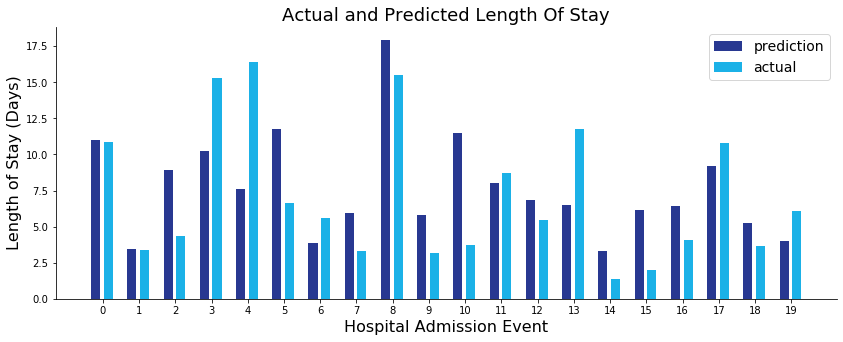

In [177]:
bidmc_deep_blue = '#283891'
bidmc_light_blue = '#1bb1e7ff'

fig, ax = plt.subplots(figsize=(14, 5))
ind = np.arange(0,20)
pad = 0.15
width = 0.35
x1 = range(0,40,2)
x2 = list(np.linspace(.7,38.7, 20))
label_loc = list(np.linspace(.4,38.4, 20))

ax.bar(x1, full_dataset_regression_predictions[:20], color=bidmc_deep_blue, width=0.5, label='prediction')
ax.bar(x2, y_test[:20], color=bidmc_light_blue, width=0.5, label='actual')

plt.title('Actual and Predicted Length Of Stay', fontsize=18)
plt.ylabel('Length of Stay (Days)', fontsize=16)
plt.xlabel('Hospital Admission Event', fontsize=16, ha='center');
plt.legend(fontsize=14)
ax.set_xticks(label_loc)
ax.set_xticklabels(list(range(20)), fontsize=10)
sns.despine()

fig.savefig('actual_vs_predicted_los.png')

<BarContainer object of 20 artists>

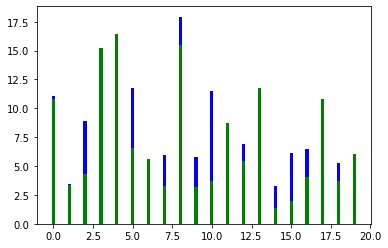

In [72]:
ax = plt.subplot(111)
x=list(range(0,20))
ax.bar(x, full_dataset_regression_predictions[:20], width=0.2, color='b', align='center')
ax.bar(x, y_test[:20], width=0.2, color='g', align='center')

(array([1184., 2299., 1775., 1009.,  611.,  383.,  276.,  158.,  132.,
         112.]),
 array([ 0.06875   ,  3.05534722,  6.04194444,  9.02854167, 12.01513889,
        15.00173611, 17.98833333, 20.97493056, 23.96152778, 26.948125  ,
        29.93472222]),
 <a list of 10 Patch objects>)

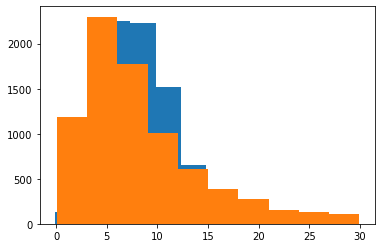

In [65]:
plt.hist(full_dataset_regression_predictions)
plt.hist(y_test)

In [66]:

# https://matplotlib.org/examples/api/barchart_demo.html
ind = np.arange(0,20)
pad = 0.15
width = 0.35
set_actual = ax.bar(pad+ind, y_test, width, color='#4c72b0', alpha=0.8)
set_predict = ax.bar(pad+ind, full_dataset_regression_predictions, width, color='#dd8452')

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [214]:
surgeries = copy_for_graphs[(copy_for_graphs.curr_service == 'VSURG') |
                            (copy_for_graphs.curr_service == 'SURG') |
                            (copy_for_graphs.curr_service == 'NB') | 
                            (copy_for_graphs.curr_service == 'MED') |
                            (copy_for_graphs.curr_service == 'DENT')] 

In [215]:
surgeries_grp = surgeries.groupby('curr_service')['los'].agg(['mean']).reset_index()
surgeries_grp = surgeries_grp.rename(columns={'mean':'mean_los'})
surgeries_grp

,curr_service,mean_los
0,DENT,7.005518
1,MED,9.729036
2,NB,6.244197
3,SURG,12.558792
4,VSURG,12.809263


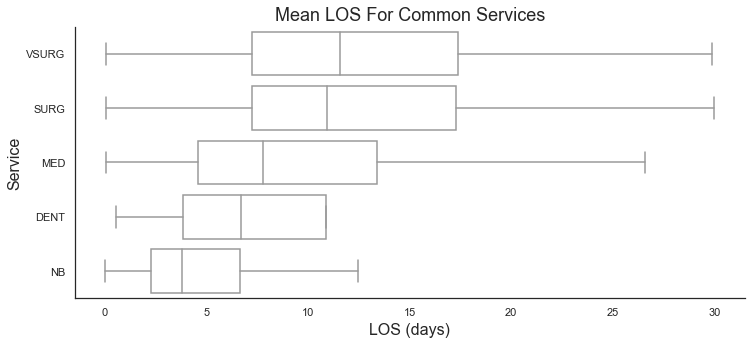

In [397]:
plt.figure(figsize=(12,5))
ethn_los = sns.boxplot(x=surgeries.los, y = surgeries.curr_service, color='white', showfliers=False, order=['VSURG','SURG','MED','DENT','NB']);
    
ethn_los.set_title('Mean LOS For Common Services', fontsize=18)
ethn_los.set_ylabel('Service', fontsize=16)
ethn_los.set_xlabel('LOS (days)', fontsize=16);
sns.despine()

plt.savefig('Services_vs_LOS.png')

In [ ]:
copy_for_graphs

In [ ]:
plt.figure(figsize=(12,6))
ethn_los = sns.barplot(x=surgeries_grp.mean_los, y = surgeries_grp.curr_service, color=bidmc_deep_blue);
    
ethn_los.set_title('Mean LOS For Common Services', fontsize=18)
ethn_los.set_ylabel('Service', fontsize=16)
ethn_los.set_xlabel('Mean LOS (days)', fontsize=16);
sns.despine()

# plt.savefig('Services_vs_LOS.png')

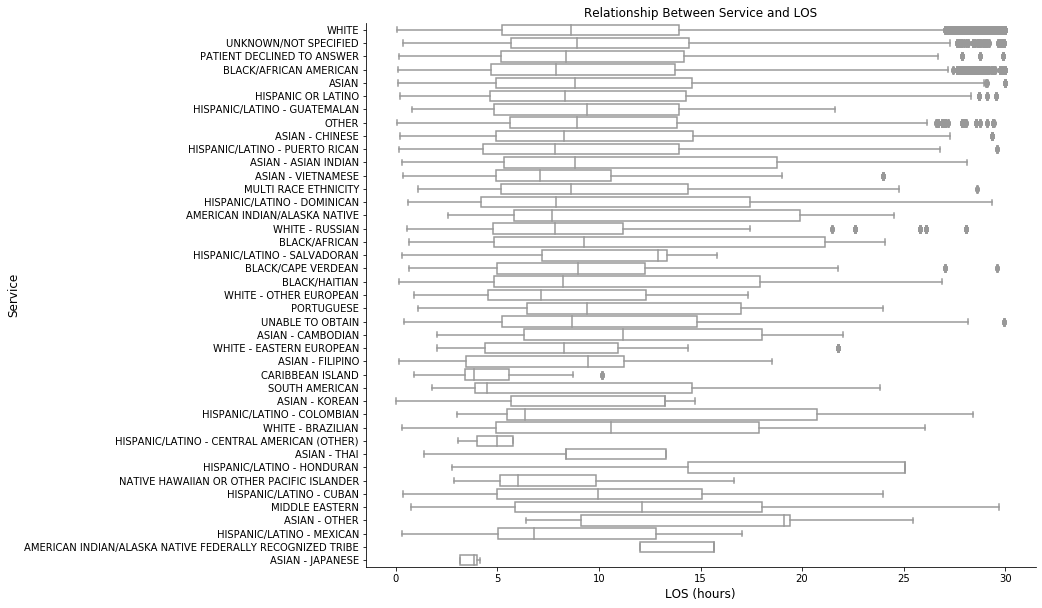

In [224]:
plt.figure(figsize=(12,10))
ethn_los = sns.boxplot(x=copy_for_graphs.los, y = copy_for_graphs.ethnicity, color='white');
    
ethn_los.set_title('Relationship Between Service and LOS', fontsize=12)
ethn_los.set_ylabel('Service', fontsize=12)
ethn_los.set_xlabel('LOS (hours)', fontsize=12);
sns.despine()

In [231]:
grp_diag = copy_for_graphs.groupby('diagnoses')['los'].agg(['mean']).reset_index()
grp_diag

,diagnoses,mean
0,Blood,10.704403
1,Circulatory_System,9.828951
2,Congenital_Anomalies,9.407592
3,Digestive_System,10.537033
4,Endocrine,9.806662
5,External_Cause_Inj_Poison,10.372562
6,Genitourinary_System,10.797253
7,Ill-Defined,10.850231
8,Injury/Poison,11.415451
9,Mental_Disorder,9.044309


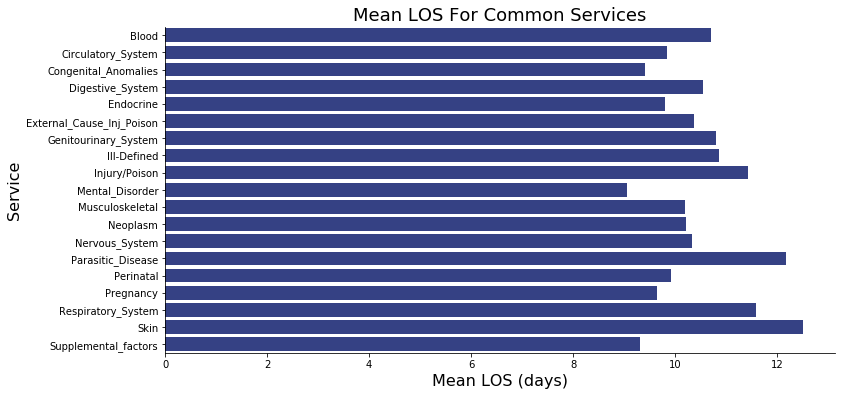

In [232]:
plt.figure(figsize=(12,6))
ethn_los = sns.barplot(x=grp_diag['mean'], y = grp_diag.diagnoses, color=bidmc_deep_blue);
    
ethn_los.set_title('Mean LOS For Common Services', fontsize=18)
ethn_los.set_ylabel('Service', fontsize=16)
ethn_los.set_xlabel('Mean LOS (days)', fontsize=16);
sns.despine()

plt.savefig('Services_vs_LOS.png')

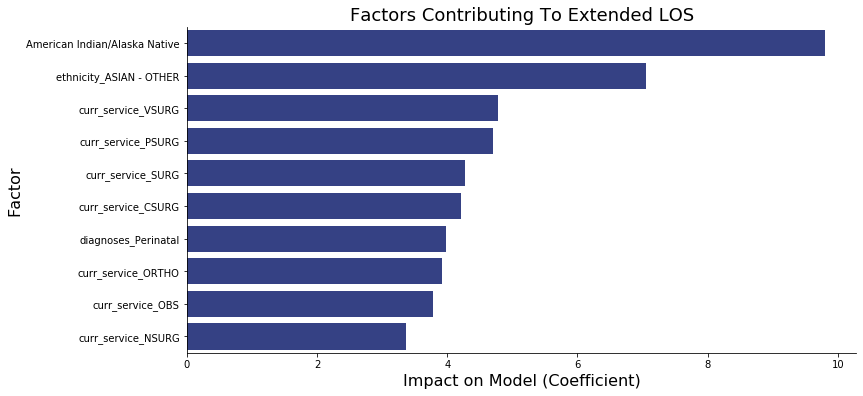

In [246]:
plt.figure(figsize=(12,6))
ethn_los = sns.barplot(x=sorted_col_coef['coef'][:10], y = sorted_col_coef.column[:10], color=bidmc_deep_blue);
    
ethn_los.set_title('Factors Contributing To Extended LOS', fontsize=18)
ethn_los.set_ylabel('Factor', fontsize=16)
ethn_los.set_xlabel('Impact on Model (Coefficient)', fontsize=16);
sns.despine()

plt.savefig('contributing_factors.png')

In [240]:
sorted_col_coef

,column,coef,p_val
42,ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERA...,9.7941,0.015
50,ethnicity_ASIAN - OTHER,7.0488,0.006
101,curr_service_VSURG,4.7716,0.000
96,curr_service_PSURG,4.7023,0.000
98,curr_service_SURG,4.2763,0.000
83,curr_service_CSURG,4.2035,0.000
120,diagnoses_Perinatal,3.9735,0.000
95,curr_service_ORTHO,3.9158,0.000
93,curr_service_OBS,3.7788,0.000
92,curr_service_NSURG,3.3707,0.000


In [378]:
cs = sorted_col_coef[sorted_col_coef['column'].str.contains('curr_serv')]
diag = sorted_col_coef[sorted_col_coef['column'].str.contains('diagnoses')]
religion = sorted_col_coef[sorted_col_coef['column'].str.contains('religion')]
ethnicity = sorted_col_coef[sorted_col_coef['column'].str.contains('ethnicity')]
adm_t = sorted_col_coef[sorted_col_coef['column'].str.contains('admission_type')]
ins = sorted_col_coef[sorted_col_coef['column'].str.contains('insurance')]

In [380]:
cs_m = cs.coef.mean()
diag_m = diag.coef.mean()
religion_m = religion.coef.mean()
ethnicity_m = ethnicity.coef.mean()
adm_t_m = adm_t.coef.mean()
ins_m = ins.coef.mean()

In [383]:
x = [cs_m, diag_m, religion_m, ethnicity_m, adm_t_m, ins_m]
y = ['service', 'diagnoses','religion','ethnicity','admission_type','insurance']

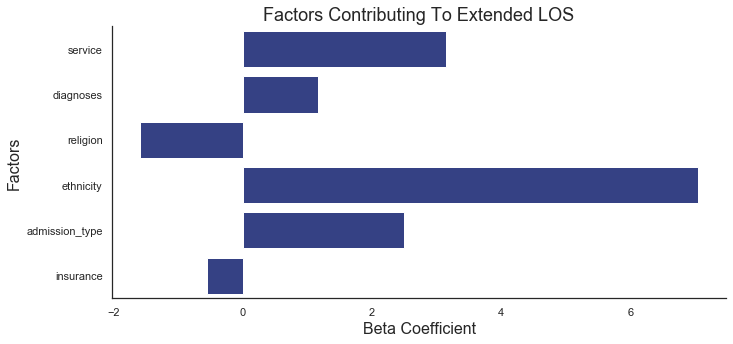

In [396]:
plt.figure(figsize=(11,5))
ethn_los = sns.barplot(x=x, y=y, color=bidmc_deep_blue);
    
ethn_los.set_title('Factors Contributing To Extended LOS', fontsize=18)
ethn_los.set_ylabel('Factors', fontsize=16)
ethn_los.set_xlabel('Beta Coefficient', fontsize=16);
sns.despine()

plt.savefig('contributing_factors.png')

In [241]:
sorted_col_coef = sorted_col_coef.replace({'ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 'American Indian/Alaska Native'})

In [242]:
sorted_col_coef

,column,coef,p_val
42,American Indian/Alaska Native,9.7941,0.015
50,ethnicity_ASIAN - OTHER,7.0488,0.006
101,curr_service_VSURG,4.7716,0.000
96,curr_service_PSURG,4.7023,0.000
98,curr_service_SURG,4.2763,0.000
83,curr_service_CSURG,4.2035,0.000
120,diagnoses_Perinatal,3.9735,0.000
95,curr_service_ORTHO,3.9158,0.000
93,curr_service_OBS,3.7788,0.000
92,curr_service_NSURG,3.3707,0.000


In [256]:
copy_for_graphs.admission_type

3         EMERGENCY
4         EMERGENCY
5         EMERGENCY
6         EMERGENCY
7         EMERGENCY
            ...    
707703     ELECTIVE
707704     ELECTIVE
707705     ELECTIVE
707706     ELECTIVE
707707     ELECTIVE
Name: admission_type, Length: 583007, dtype: object

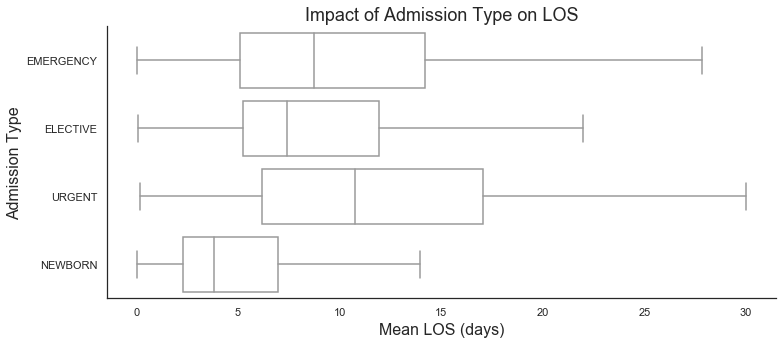

In [277]:
plt.figure(figsize=(12,5))

ethn_los = sns.boxplot(x=copy_for_graphs.los, y = copy_for_graphs.admission_type,color='white', showfliers=False);
sns.set_style('white')    
ethn_los.set_title('Impact of Admission Type on LOS', fontsize=18)
ethn_los.set_ylabel('Admission Type', fontsize=16)
ethn_los.set_xlabel('Mean LOS (days)', fontsize=16);
sns.despine()

plt.savefig('Admission_type_vs_LOS.png')

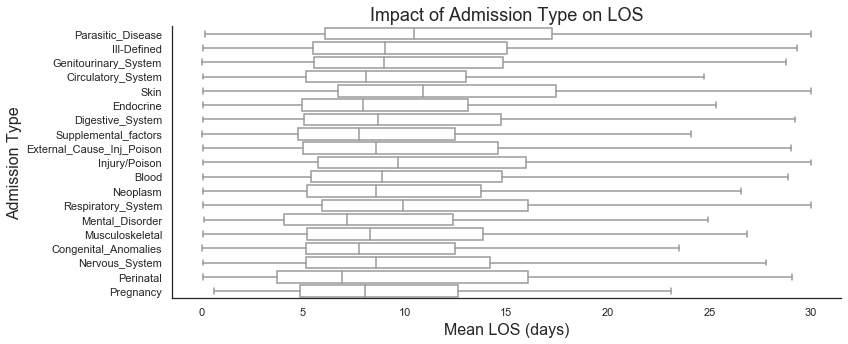

In [279]:
plt.figure(figsize=(12,5))

ethn_los = sns.boxplot(x=copy_for_graphs.los, y = copy_for_graphs.diagnoses,color='white', showfliers=False);
sns.set_style('white')    
ethn_los.set_title('Impact of Admission Type on LOS', fontsize=18)
ethn_los.set_ylabel('Admission Type', fontsize=16)
ethn_los.set_xlabel('Mean LOS (days)', fontsize=16);
sns.despine()

plt.savefig('Admission_type_vs_LOS.png')

In [280]:
copy_for_graphs.los.mean()

10.30933608596848

In [281]:
3.75/copy_for_graphs.los.mean()

0.36374796288811817

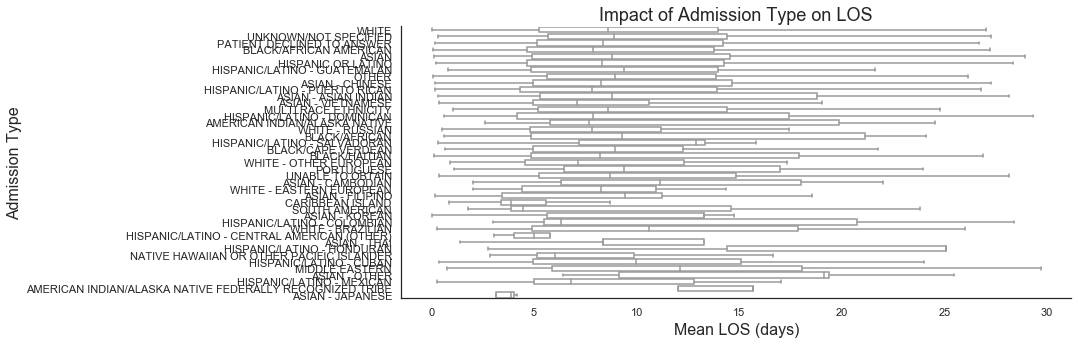

In [282]:
plt.figure(figsize=(12,5))

ethn_los = sns.boxplot(x=copy_for_graphs.los, y = copy_for_graphs.ethnicity,color='white', showfliers=False);
sns.set_style('white')    
ethn_los.set_title('Impact of Admission Type on LOS', fontsize=18)
ethn_los.set_ylabel('Admission Type', fontsize=16)
ethn_los.set_xlabel('Mean LOS (days)', fontsize=16);
sns.despine()

# plt.savefig('Admission_type_vs_LOS.png')

In [356]:
ehnicity_grp = copy_for_graphs.groupby('ethnicity')['los'].agg(['mean'])

In [357]:
ehnicity_grp = ehnicity_grp.sort_values(by='mean', ascending=False).reset_index()

In [358]:
ehnicity_grp

,ethnicity,mean
0,HISPANIC/LATINO - HONDURAN,19.610303
1,ASIAN - OTHER,16.314350
2,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,14.449306
3,MIDDLE EASTERN,13.212063
4,BLACK/AFRICAN,12.205038
5,HISPANIC/LATINO - COLOMBIAN,12.153353
6,ASIAN - CAMBODIAN,11.964308
7,WHITE - BRAZILIAN,11.858462
8,ASIAN - ASIAN INDIAN,11.532097
9,PORTUGUESE,11.507319


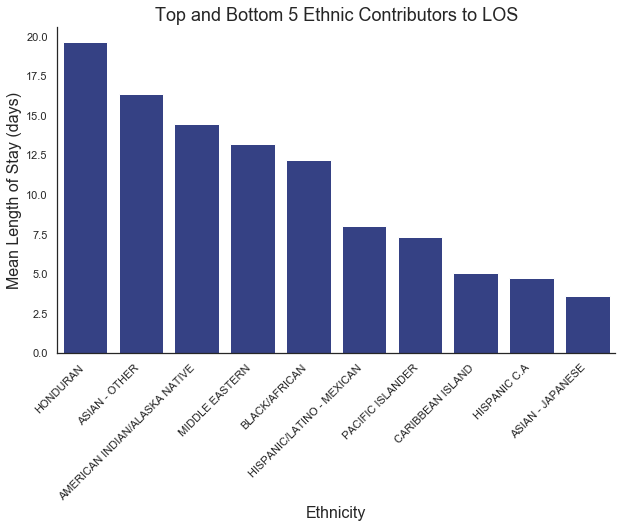

In [362]:
plt.figure(figsize=(10,6))
ethn_los = sns.barplot(x=ehnicity_grp_select['ethnicity'], y = ehnicity_grp_select['mean'], color=bidmc_deep_blue);
    
ethn_los.set_title('Top and Bottom 5 Ethnic Contributors to LOS', fontsize=18)
ethn_los.set_ylabel('Mean Length of Stay (days)', fontsize=16)
ethn_los.set_xlabel('Ethnicity', fontsize=16);
plt.xticks(rotation=45, ha='right')
sns.despine()

plt.savefig('ethnicity_low.png')

In [363]:
ehnicity_grp = ehnicity_grp.replace({'HISPANIC/LATINO - HONDURAN': 'HONDURAN', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 'AMERICAN INDIAN/ALASKA NATIVE', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)': 'HISPANIC C.A', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'PACIFIC ISLANDER'})
copy_for_graphs = copy_for_graphs.replace({'HISPANIC/LATINO - HONDURAN': 'HONDURAN', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 'AMERICAN INDIAN/ALASKA NATIVE', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)': 'HISPANIC C.A', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'PACIFIC ISLANDER'})

In [360]:
ehnicity_grp_select = pd.concat((ehnicity_grp[:5], ehnicity_grp[-5:]), axis=0) 
ehnicity_grp_select

,ethnicity,mean
0,HONDURAN,19.610303
1,ASIAN - OTHER,16.314350
2,AMERICAN INDIAN/ALASKA NATIVE,14.449306
3,MIDDLE EASTERN,13.212063
4,BLACK/AFRICAN,12.205038
36,HISPANIC/LATINO - MEXICAN,7.976329
37,PACIFIC ISLANDER,7.287730
38,CARIBBEAN ISLAND,5.011355
39,HISPANIC C.A,4.708078
40,ASIAN - JAPANESE,3.610447


In [341]:
ehnicity_grp_select

,index,ethnicity,mean
0,0,HONDURAN,19.610303
1,1,ASIAN - OTHER,16.314350
2,2,American Indian/Alaska Native,14.449306
3,3,MIDDLE EASTERN,13.212063
4,4,BLACK/AFRICAN,12.205038
36,36,HISPANIC/LATINO - MEXICAN,7.976329
37,37,PACIFIC ISLANDER,7.287730
38,38,CARIBBEAN ISLAND,5.011355
39,39,HISPANIC C.A,4.708078
40,40,ASIAN - JAPANESE,3.610447


In [336]:
sorted_col_coef = sorted_col_coef.replace({'ethnicity_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 'AMERICAN INDIAN/ALASKA NATIVE'})

In [366]:
copy_for_graphs2 = copy_for_graphs[(copy_for_graphs.ethnicity== 'HONDURAN') |
                (copy_for_graphs.ethnicity== 'ASIAN - OTHER') | 
               (copy_for_graphs.ethnicity== 'AMERICAN INDIAN/ALASKA NATIVE') |
               (copy_for_graphs.ethnicity== 'MIDDLE EASTERN') |
               (copy_for_graphs.ethnicity== 'BLACK/AFRICAN') |
               (copy_for_graphs.ethnicity== 'HISPANIC/LATINO - MEXICAN') |
               (copy_for_graphs.ethnicity== 'PACIFIC ISLANDER') |
               (copy_for_graphs.ethnicity== 'CARIBBEAN ISLAND') |
               (copy_for_graphs.ethnicity== 'HISPANIC C.A') |
               (copy_for_graphs.ethnicity== 'ASIAN - JAPANESE')
               ]

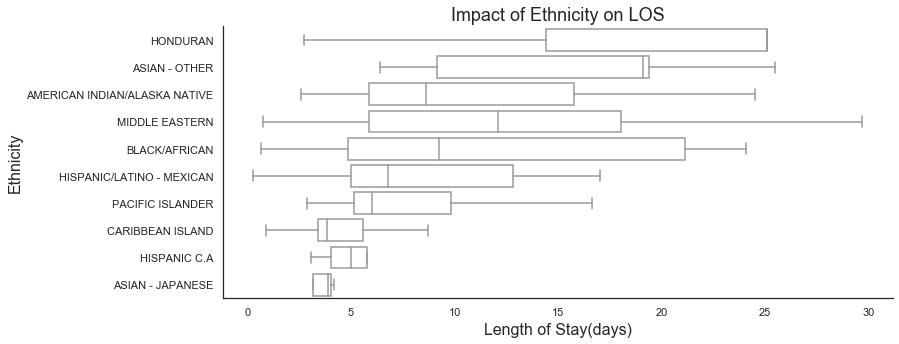

In [370]:
plt.figure(figsize=(12,5))
order = ['HONDURAN', 'ASIAN - OTHER', 'AMERICAN INDIAN/ALASKA NATIVE', 'MIDDLE EASTERN','BLACK/AFRICAN','HISPANIC/LATINO - MEXICAN','PACIFIC ISLANDER','CARIBBEAN ISLAND','HISPANIC C.A','ASIAN - JAPANESE']

ethn_los = sns.boxplot(x=copy_for_graphs2.los, y = copy_for_graphs2.ethnicity,color='white', order=order, showfliers=False);
sns.set_style('white')    
ethn_los.set_title('Impact of Ethnicity on LOS', fontsize=18)
ethn_los.set_ylabel('Ethnicity', fontsize=16)
ethn_los.set_xlabel('Length of Stay(days)', fontsize=16);
sns.despine()

plt.savefig('Ethnicity_on_LOS.png')

In [372]:
copy_for_graphs2.ethnicity.value_counts()

MIDDLE EASTERN                   561
BLACK/AFRICAN                    543
AMERICAN INDIAN/ALASKA NATIVE    284
HISPANIC C.A                     185
PACIFIC ISLANDER                 175
ASIAN - OTHER                    161
HISPANIC/LATINO - MEXICAN        128
CARIBBEAN ISLAND                 114
HONDURAN                          73
ASIAN - JAPANESE                  23
Name: ethnicity, dtype: int64